In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
import json
import pickle
import functools
import joblib

In [36]:
import statsmodels.tsa.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import tqdm

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

In [6]:
%%time
with open("./data/fundamentals_SP500.json", "r") as fin:
    fundamentals = json.load(fin)

CPU times: total: 1.59 s
Wall time: 2 s


In [7]:
symbols = list(fundamentals.keys())
cols = [
          #"totalStockholderEquity",
          "totalAssets", "totalLiab",
          "cash", "inventory",
          "totalCurrentAssets", "totalCurrentLiabilities", 
         ]

In [8]:
sym = "AAPL"

df = pd.json_normalize(
        fundamentals[sym]['Financials']["Balance_Sheet"]["quarterly"].values(),   
)

In [9]:
df["date"] = pd.to_datetime(df["date"])

In [34]:
df.head()

,date,filing_date,currency_symbol,totalAssets,intangibleAssets,earningAssets,otherCurrentAssets,totalLiab,totalStockholderEquity,deferredLongTermLiab,otherCurrentLiab,commonStock,capitalStock,retainedEarnings,otherLiab,goodWill,otherAssets,cash,cashAndEquivalents,totalCurrentLiabilities,currentDeferredRevenue,netDebt,shortTermDebt,shortLongTermDebt,shortLongTermDebtTotal,otherStockholderEquity,propertyPlantEquipment,totalCurrentAssets,longTermInvestments,netTangibleAssets,shortTermInvestments,netReceivables,longTermDebt,inventory,accountsPayable,totalPermanentEquity,noncontrollingInterestInConsolidatedEntity,temporaryEquityRedeemableNoncontrollingInterests,accumulatedOtherComprehensiveIncome,additionalPaidInCapital,commonStockTotalEquity,preferredStockTotalEquity,retainedEarningsTotalEquity,treasuryStock,accumulatedAmortization,nonCurrrentAssetsOther,deferredLongTermAssetCharges,nonCurrentAssetsTotal,capitalLeaseObligations,longTermDebtTotal,nonCurrentLiabilitiesOther,nonCurrentLiabilitiesTotal,negativeGoodwill,warrants,preferredStockRedeemable,capitalSurpluse,liabilitiesAndStockholdersEquity,cashAndShortTermInvestments,propertyPlantAndEquipmentGross,propertyPlantAndEquipmentNet,accumulatedDepreciation,netWorkingCapital,netInvestedCapital,commonStockSharesOutstanding
0,2022-06-30,2022-07-29,USD,336309000000.00,None,None,16386000000.00,278202000000.00,58107000000.00,None,48811000000.00,62115000000.00,62115000000.00,5289000000.00,53629000000.00,None,52605000000.00,27502000000.00,14650000000.00,129873000000.00,7728000000.00,92189000000.00,24991000000.00,24991000000.00,119691000000.00,-9297000000.00,40335000000.00,112292000000.00,131077000000.00,58107000000.00,20729000000.00,42242000000.00,94700000000.00,5433000000.00,48343000000.00,None,None,None,-9297000000.00,None,62115000000.00,None,5289000000.00,None,None,52605000000.00,None,224017000000.00,None,94700000000.00,53629000000.00,148329000000.00,None,None,None,None,336309000000.00,48231000000.00,None,40335000000.00,None,-17581000000.00,177798000000.00,16262203000.00
1,2022-03-31,2022-04-29,USD,350662000000.00,None,None,15809000000.00,283263000000.00,67399000000.00,None,50248000000.00,61181000000.00,61181000000.00,12712000000.00,52432000000.00,None,51959000000.00,28098000000.00,13800000000.00,127508000000.00,7920000000.00,91883000000.00,16658000000.00,16658000000.00,119981000000.00,-6494000000.00,39304000000.00,118180000000.00,141219000000.00,67399000000.00,23413000000.00,45400000000.00,103323000000.00,5460000000.00,52682000000.00,None,None,None,-6494000000.00,None,61181000000.00,None,12712000000.00,None,None,51959000000.00,None,232482000000.00,None,103323000000.00,52432000000.00,155755000000.00,None,None,None,None,350662000000.00,51511000000.00,None,39304000000.00,None,-9328000000.00,187380000000.00,16519291000.00
2,2021-12-31,2022-01-28,USD,381191000000.00,None,None,18112000000.00,309259000000.00,71932000000.00,None,49167000000.00,58424000000.00,58424000000.00,14435000000.00,55056000000.00,None,50109000000.00,37119000000.00,19127000000.00,147574000000.00,7876000000.00,85679000000.00,16169000000.00,16169000000.00,122798000000.00,-927000000.00,39245000000.00,153154000000.00,138683000000.00,71932000000.00,26794000000.00,65253000000.00,106629000000.00,5876000000.00,74362000000.00,None,None,None,-927000000.00,None,58424000000.00,None,14435000000.00,None,None,50109000000.00,None,228037000000.00,None,106629000000.00,55056000000.00,161685000000.00,None,None,None,None,381191000000.00,63913000000.00,None,39245000000.00,None,5580000000.00,194730000000.00,16519291000.00
3,2021-09-30,2021-10-29,USD,351002000000.00,None,None,14111000000.00,287912000000.00,63090000000.00,None,47493000000.00,57365000000.00,57365000000.00,5562000000.00,43050000000.00,None,38762000000.00,34940000000.00,17635000000.00,125481000000.00,7612000000.00,89779000000.00,15613000000.00,15613000000.00,124719000000.00,163000000.00,49527000000.00,134836000000.00,127877000000.00,63090000000.00,27699000000.00,51506000000.00,1091

In [35]:
# The JSON covers much longer time frames
df["date"].min()

Timestamp('1985-09-30 00:00:00')

In [10]:
# pandas_profiling.ProfileReport(df, interactions=None).to_file("./sp500_bs_q.html")

# VAR model

# Apply the baseline to all symbols

In [21]:
def ret_none_if_error(f):
    @functools.wraps(f)
    def wrapped(*args, **kwargs):
        try:
            ret = f(*args, **kwargs)
        except:
            ret = None
        return ret

    return wrapped

In [28]:
@ret_none_if_error
def get_baseline(sym, df, var_deg=2, arima_order=(4, 0, 2)):
    # One model for each symbol
    df["date"] = pd.to_datetime(df["date"])
    
    # Convert the values to pct change over the last period
    diff = df.set_index("date")[cols]\
             .sort_index().astype(float)\
             .pct_change(1).iloc[1:, :]\
        
    
    # Out of time testing
    train = diff.loc["2014-12-31": "2020-12-31"]
    test = diff.loc["2021-1-1":]
    
    n_forecast = len(test)
    ret = {}
    
    # Mean(train)
    MAE_mean = abs(test - train.mean()).mean()

    #### Can't fit VAR with this data volume; O(K^2) params to estimate
#     # VAR
#     m = sm.VAR(train)
#     rst = m.fit(var_deg)
#     yhat_var = rst.forecast(train.iloc[-var_deg:].to_numpy(), n_forecast)
    
#     MAE_var = abs(yhat_var - test).mean()
    
    # ARIMA
    m_arima = {}
    MAE_arima = {}
    for c in train.columns:
        arima = sm.arima.ARIMA(train[c], order=arima_order)
        res = arima.fit()

        m_arima[c] = res
        mae = abs(res.forecast(n_forecast) - test[c]).mean()

        MAE_arima[c] = mae
        
    MAE_arima = pd.Series(MAE_arima)
    
    concat = pd.concat({"mean": MAE_mean,
                        #"var": MAE_var,
                        "arima": MAE_arima})
    return pd.DataFrame([concat], index=[sym])


In [29]:
# Don't operate on the json inside the function; pickling the entire json is expensive
# Instead, pass df as a param, and joblib will take care of it by pre-dispatch
# (Alternatively, make the json a shared var)

baselines = joblib.Parallel(n_jobs=-2, backend="loky")(
    joblib.delayed(get_baseline)(sym,
                                 pd.json_normalize(
                                     fundamentals[sym]['Financials']["Balance_Sheet"]["quarterly"].values()
                                 ))
    for sym in tqdm.tqdm(symbols)
)

100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [00:34<00:00, 14.77it/s]


In [30]:
baselines_df = pd.concat([b for b in baselines if b is not None])
baselines_df.sample(5, random_state=5)

mean                                                   \
     totalAssets totalLiab      cash inventory totalCurrentAssets   
CF      0.036511  0.062328  0.390390  0.199721           0.180842   
UDR     0.023082  0.048778  6.812537  0.089767           1.801093   
MCD     0.029862  0.057722  0.390272  0.089968           0.126840   
FRT     0.017474  0.036079  0.992698       NaN           0.242619   
NTRS    8.662518  0.065733  0.264443  2.907143         650.558268   

                                   arima                                \
     totalCurrentLiabilities totalAssets totalLiab      cash inventory   
CF                  0.391294    0.040236  0.061685  0.522746  0.107762   
UDR                 0.212123    0.023489  0.051095  6.698419  0.190376   
MCD                 0.204307    0.047599  0.070100  0.561989  0.072260   
FRT                 0.337355    0.021214  0.049240  1.451500       NaN   
NTRS               31.692794    6.928013  0.069357  0.255144  2.761728   

                                                 
     totalCurrentAssets totalCurrentLiabilities  
CF             0.230895                0.270036  
UDR            1.906963                0.336664  
MCD            0.148433                0.240323  
FRT            0.235984                0.344869  
NTRS         675.963593               34.479265

In [31]:
#baselines_df.to_pickle("./baselines.pickle")

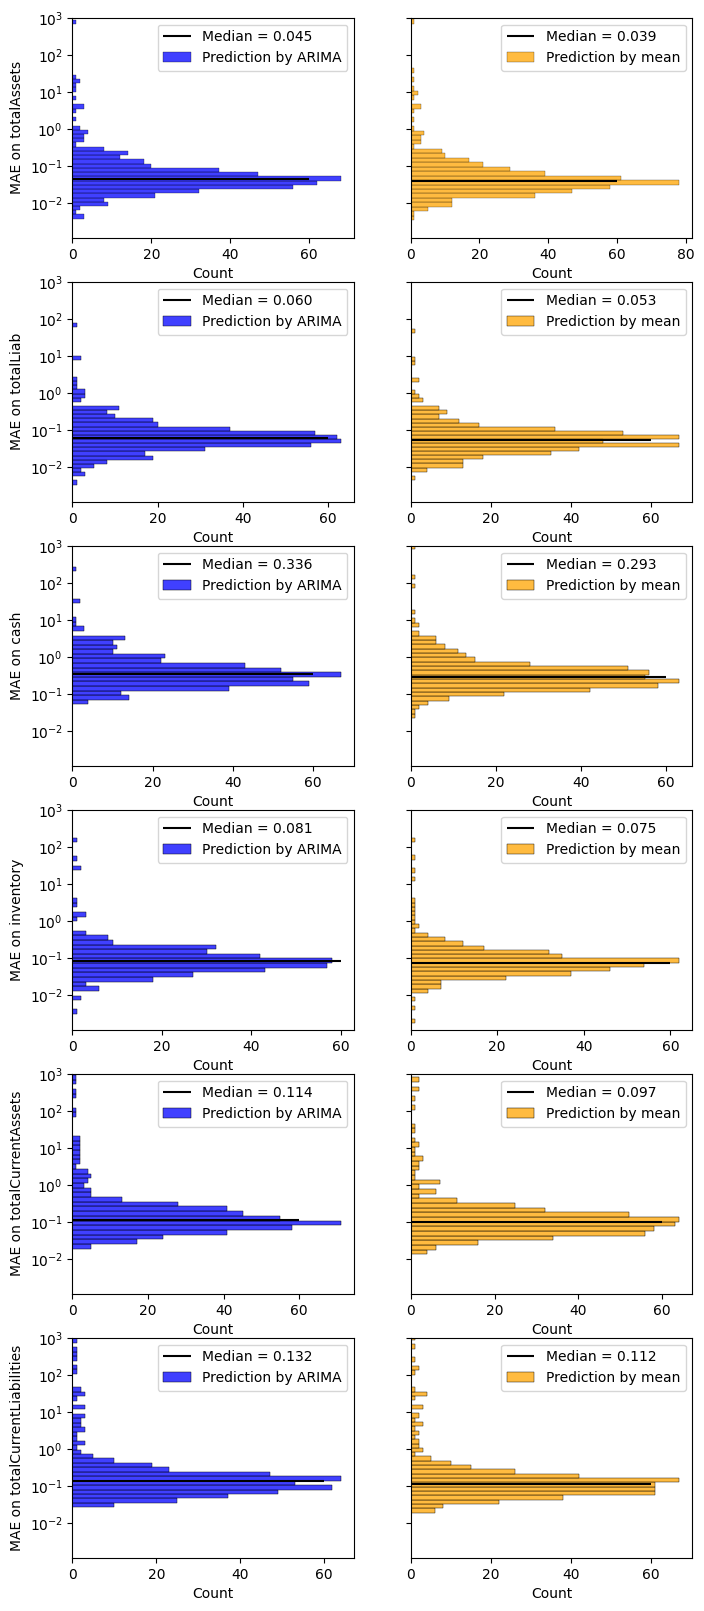

In [37]:
fig, ax = plt.subplots(len(cols), 2, sharey=True, figsize=(8, 20))

# 0 causes log_scale to fail
baselines_df.replace([0], 1e-9, inplace=True)

for i, col in enumerate(cols):
    sns.histplot(data=baselines_df, y=("arima", col), ax=ax[i][0], log_scale=True, label="Prediction by ARIMA", color="blue")
    med = baselines_df[("arima", col)].median()     # Mean is dominated by outliers
    ax[i][0].hlines(baselines_df[("arima", col)].median(), 0, 60, color="black", label=f"Median = {med:.3f}")
    ax[i][0].legend()

    sns.histplot(data=baselines_df, y=("mean", col), ax=ax[i][1], log_scale=True, label="Prediction by mean", color="orange")
    med = baselines_df[("mean", col)].median()    # Mean is dominated by outliers
    ax[i][1].hlines(med, 0, 60, color="black", label=f"Median = {med:.3f}")
    ax[i][1].legend()
    
    ax[i][1].set_ylim(0, 1e3)
    ax[i][1].minorticks_off()
    ax[i][0].set_ylabel(f"MAE on {col}")